In [ ]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import shutil
import statistics
import math
import scipy.io as sio
from scipy.signal import find_peaks
from scipy.spatial import distance
from scipy.stats import kurtosis, skew
from scipy import signal
from scipy import stats
from sklearn.metrics import accuracy_score
from scipy.fftpack import fft,ifft
from matplotlib.pylab import mpl
from numpy import fft
from sklearn.preprocessing import Normalizer

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd  NinaproDB2/
!ls

[Errno 2] No such file or directory: 'NinaproDB2/'
/content/gdrive/My Drive/trial_period_work/NinaproDB2
DB2_s16      DB2_s24	  DB2_s8.zip	 S35_E3_A1.mat	S8_E1_A1.mat
DB2_s16.zip  DB2_s24.zip  __MACOSX	 S36_E1_A1.mat	S8_E2_A1.mat
DB2_s20.zip  DB2_s25	  S20_E1_A1.mat  S36_E2_A1.mat	S8_E3_A1.mat
DB2_s22      DB2_s25.zip  S20_E2_A1.mat  S36_E3_A1.mat
DB2_s22.zip  DB2_s35.zip  S20_E3_A1.mat  S38_E1_A1.mat
DB2_s23      DB2_s36.zip  S35_E1_A1.mat  S38_E2_A1.mat
DB2_s23.zip  DB2_s38.zip  S35_E2_A1.mat  S38_E3_A1.mat


In [ ]:
trial_data = loadmat('S38_E1_A1.mat') 
print(trial_data.keys())
#'emg', 'acc', 'stimulus', 'glove', 'inclin', 'subject', 'exercise', 'repetition', 'restimulus', 'rerepetition'

dict_keys(['__header__', '__version__', '__globals__', 'emg', 'acc', 'stimulus', 'glove', 'inclin', 'subject', 'exercise', 'repetition', 'restimulus', 'rerepetition'])


VARIABLES IN THE FILES:
- subject: subject number
- exercise: exercise number **Look at paper for more notes, there are three primary exercise types**
- stimulus (1 column): the movement repeated by the subject.
- restimulus (1 column): again the movement repeated by the subject. In this case the duration of the movement label is refined a-posteriori in order to better correspond to the real movement (please, use the paper Gijsberts et al., 2014 (http://publications.hevs.ch/index.php/publications/show/1629) for more details about relabelling procedure) **This is the classification label**
- repetition (1 column): repetition of the stimulus
- rerepetition (1 column): repetition of restimulus
- emg (12 columns): sEMG signal of the 12 electrodes **This is the primary input data**
- acc (36 columns): three-axes accelerometers of the 12 electrodes **This is additional input data that can optionally be used to improve performance**
- inclin (2 columns): signal from the 2 axes inclinometer positioned on the wrist
- glove (22 columns): uncalibrated signal from the 22 sensors of the cyberglove. The cyberglove signal corresponds to raw data from the cyberglove sensors, which are declared to be proportional to the angles at the joints in the CyberGlove manual. **This is the regression output value -- these values are uncalibrated, send a message if you want the calibrated values**
- force (6 columns): force recorded during the third exercise
- forcecal (2 x 6 values): the force sensors calibration values, corresponding to the minimal and the maximal force.

In [ ]:
print("EMG",trial_data['emg'].shape)
print("acc",trial_data['acc'].shape)
print("glove",trial_data['glove'].shape)
print("inclin",trial_data['inclin'].shape)
print("subject",trial_data['subject'])
print("exercise",trial_data['exercise'])
print("repetition",trial_data['repetition'].shape)
print("restimulus",trial_data['restimulus'].shape)
print("rerepetition",trial_data['rerepetition'].shape)

EMG (1773208, 12)
acc (1773208, 36)
glove (1773208, 22)
inclin (1773208, 2)
subject [[38]]
exercise [[1]]
repetition (1773208, 1)
restimulus (1773208, 1)
rerepetition (1773208, 1)


In [ ]:
def NumOfWindows(total, window_length,overlap):
  merge = True
  timeleap = window_length-overlap
  tolerance = window_length*0.6 #represents the minimum acceptable window length
  #if the last window is not at least 60% of the expected window_length, it will be not be recognized as a seperate window
  #instead it will be combine with the second last window to make one extra large window
  num_windows = ((total-window_length)//timeleap)+1
  # print(num_windows)
  rem = total - (((num_windows-1)*timeleap)+window_length)
  # print(rem, tolerance)
  if(rem>=tolerance):
    merge = False
    num_windows = num_windows+1
  return num_windows,merge

In [ ]:
def GenerateFeatures(samples):
  miu0 = np.sqrt(np.sum(samples**2))
  samples_fft = fft.fft(samples)
  K = np.arange(0,len(samples))
  miu2 = np.sqrt(np.sum((K*samples_fft)**2)/window_size)
  # print(len(K),len(samples_fft))
  miu4 = np.sqrt(np.sum((K**2*samples_fft)**2) / window_size**2)
  num_of_peaks = miu4 / miu2
  f0 = miu0-miu2
  f1 = miu0 / num_of_peaks
  f2 = miu2 / num_of_peaks
  f3 = miu2
  total_features = [f0,f1,f2,f3]
  return total_features




In [ ]:
def getWindowLabel(window):
  mode, counts = stats.mode(window)
  diff = counts/len(window)
  if (diff>0.6): #if the majority label is more than 60% of the window set as label
    label = mode[0][0]
  else: #else set last label as window label
    last = len(window)
    label = window[last-1][0]
  return label

In [ ]:
def ReverseModeWindow(orginal_length,mode_windows,window_size,overlap,merge):
  reversedWindows = np.zeros(orginal_length)
  timeleap = window_size-overlap
  num_windows = len(mode_windows)
  start = 0
  end = start+window_size
  for i in range(1,num_windows+1):
    reversedWindows[start:end] = mode_windows[i-1]
    start = start + timeleap
    end = start + window_size
    if(merge and i == num_windows-1): 
      end = orginal_length
  return reversedWindows

In [ ]:
def GetFeatureData(f,window_length,overlap,num_features):
  timeleap = window_length-overlap 
  trial_data = loadmat(f) 
  trail_label = trial_data['restimulus']
  trial_data = trial_data['emg']
  total = trial_data.shape[0] # 1773208 rows / total samples
  num_windows,merge= NumOfWindows(total, window_length,overlap)
  featureData = np.zeros((num_windows,num_features*12))
  featureLabel = np.zeros(num_windows) # number of labels 
  ind = 0
  windowStart = 0
  windowEnd = windowStart + window_length
  while(ind<num_windows):
    window = trail_label[windowStart:windowEnd]
    label = getWindowLabel(window) # get a label for a window
    featured_data = np.zeros((num_features*12))
    for j in range(12):
      # print("start",windowStart,"end",windowEnd)
      sig = trial_data[windowStart:windowEnd,j] # for every columns / channels
      features = GenerateFeatures(sig) # generate corresponding features for a window
      features = np.array(features)
      featured_data[num_features*(j):num_features*(j+1)] = features
    windowStart = windowStart + timeleap
    windowEnd = windowStart + window_length
    if(merge and ind == num_windows-1): 
      end = total
    featured_data = np.nan_to_num(featured_data)
    # print(ind)
    featureData[ind,:]= featured_data
    featureLabel[ind] = label
    ind = ind + 1
  # print(featureData.shape)
  # print(featureLabel.shape)
  return featureData,featureLabel,merge

In [ ]:
def GetDataOverSubject(subjectNum,exerNum,window_length,overlap,num_features):
  All_Data = np.zeros((num_features*12))
  All_Labels = np.zeros((1))
  Estimated_Labels = np.zeros((1))
  All_Real_Labels = np.zeros((1,1))
  for sub in subjectNum:
    print("Subject",sub)
    f = 'S%s_E%s_A1.mat' % (sub,exerNum)
    label = loadmat(f) 
    label = label['rerepetition']
    # print(label.shape)
    All_Real_Labels =  np.vstack((All_Real_Labels, label))#the actual labels
    # print(All_Real_Labels.shape)
    featureData,featureLabel,merge = GetFeatureData(f,window_length,overlap,num_features)
    All_Data = np.vstack((All_Data,featureData))
    All_Labels = np.hstack((All_Labels,featureLabel)) #windowed labels
    estimated_label = ReverseModeWindow(len(label),featureLabel,window_length,overlap,merge) 
    Estimated_Labels = np.hstack((Estimated_Labels, estimated_label)) #windowed labels supersampled
  All_Data = All_Data[1:len(All_Data),:]
  All_Labels = All_Labels[1:len(All_Labels)]
  Estimated_Labels = Estimated_Labels[1:len(Estimated_Labels)]
  All_Real_Labels = All_Real_Labels[1:len(All_Real_Labels),:]
  return All_Data,All_Labels,Estimated_Labels,All_Real_Labels

In [ ]:
window_size = 300
overlap = 50
delay = (window_size-overlap)/600
# print("The delay in prediction is ", delay, "seconds")
# if (delay > 0.3):
#   print("WARNING! YOUR DELAY IS TOO LARGE!")
features = 4
train_subjects = ['8','36','38']
train_data,train_labels,train_estimated_labels,train_real_labels = GetDataOverSubject(train_subjects,'1',window_size,overlap,features)
test_1 = ['20']
test_2 = ['35']
test_data1,test_labels1,test_estimated_labels1,test_real_labels1 = GetDataOverSubject(test_1,'1',window_size,overlap,features)
test_data2,test_labels2,test_estimated_labels2,test_real_labels2 = GetDataOverSubject(test_2,'1',window_size,overlap,features)
print("Training Feature Data",train_data.shape,"Training Feature Labels",train_labels.shape)
print("Training True Label",train_real_labels.shape,"Train expanded labels",train_estimated_labels.shape)
print("Test 1 Feature Data",test_data1.shape,"Test 1  Feature Labels",test_estimated_labels1.shape)
print("Test 1  True Label",test_real_labels1.shape,"Test 1  expanded labels",test_estimated_labels1.shape)
print("Test 2  Feature Data",test_data2.shape,"Test 2 Feature Labels",test_labels2.shape)
print("Test 2 True Label",test_real_labels2.shape,"Test 2 expanded labels",test_estimated_labels2.shape)

Subject 8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part


Subject 36
Subject 38
Subject 20
Subject 35
Training Feature Data (21393, 48) Training Feature Labels (21393,)
Training True Label (5348544, 1) Train expanded labels (5348544,)
Test 1 Feature Data (7205, 48) Test 1  Feature Labels (1801389,)
Test 1  True Label (1801389, 1) Test 1  expanded labels (1801389,)
Test 2  Feature Data (7078, 48) Test 2 Feature Labels (7078,)
Test 2 True Label (1769567, 1) Test 2 expanded labels (1769567,)


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
transformer = Normalizer().fit(train_data)
tranformed_train_data = transformer.transform(train_data)
tranformed_test_data1 = transformer.transform(test_data1)
tranformed_test_data2 = transformer.transform(test_data2)
clf = LinearDiscriminantAnalysis()
clf.fit(tranformed_train_data,train_labels)
pred1 = clf.predict(tranformed_test_data1)
pred2 = clf.predict(tranformed_test_data2)
acc1 = accuracy_score(test_labels1, pred1)
acc2 = accuracy_score(test_labels2, pred2)
print("Test 1 Accuracy",acc1)
print("Test 2 Accuracy",acc2)
mean_acc = (acc1+acc2)/2
print("Average Test Accuracy",mean_acc)

Test 1 Accuracy 0.4484385843164469
Test 2 Accuracy 0.3224074597343882
Average Test Accuracy 0.38542302202541756


In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
transformer = Normalizer().fit(train_data)
tranformed_train_data = transformer.transform(train_data)
tranformed_test_data1 = transformer.transform(test_data1)
tranformed_test_data2 = transformer.transform(test_data2)
clf = QuadraticDiscriminantAnalysis()
clf.fit(tranformed_train_data,train_labels)
pred1 = clf.predict(tranformed_test_data1)
pred2 = clf.predict(tranformed_test_data2)
acc1 = accuracy_score(test_labels1, pred1)
acc2 = accuracy_score(test_labels2, pred2)
print("Test 1 Accuracy",acc1)
print("Test 2 Accuracy",acc2)
mean_acc = (acc1+acc2)/2
print("Average Test Accuracy",mean_acc)

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Test 1 Accuracy 0.04011103400416378
Test 2 Accuracy 0.21263068663464255
Average Test Accuracy 0.12637086031940317


In [ ]:
from sklearn import svm
transformer = Normalizer().fit(train_data)
tranformed_train_data = transformer.transform(train_data)
tranformed_test_data1 = transformer.transform(test_data1)
tranformed_test_data2 = transformer.transform(test_data2)
clf = svm.SVC()
clf.fit(tranformed_train_data,train_labels)
pred1 = clf.predict(tranformed_test_data1)
pred2 = clf.predict(tranformed_test_data2)
acc1 = accuracy_score(test_labels1, pred1)
acc2 = accuracy_score(test_labels2, pred2)
print("Test 1 Accuracy",acc1)
print("Test 2 Accuracy",acc2)
mean_acc = (acc1+acc2)/2
print("Average Test Accuracy",mean_acc)

Test 1 Accuracy 0.4439972241498959
Test 2 Accuracy 0.3174625600452105
Average Test Accuracy 0.3807298920975532


Measured Accuracy -- mode labels vs real labels 0.4439972241498959


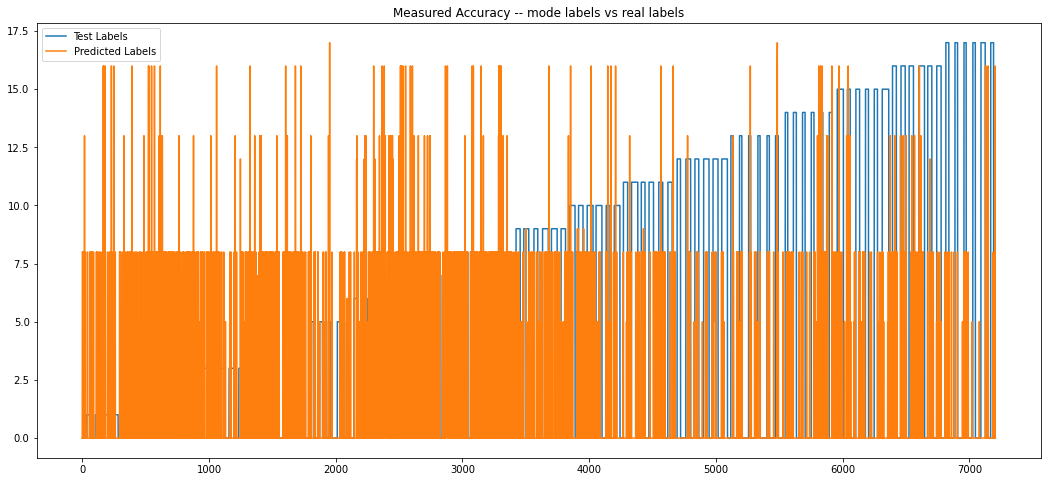

In [ ]:
print('Measured Accuracy -- mode labels vs real labels',accuracy_score(test_labels1, pred1))
plt.figure(figsize=(18,8))
plt.title('Measured Accuracy -- mode labels vs real labels')
plt.plot(test_labels1)
plt.plot(pred1)
plt.legend(['Test Labels','Predicted Labels'])
plt.show()

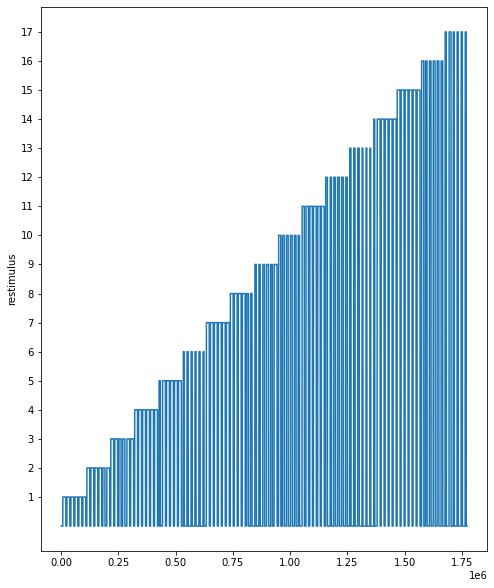

In [ ]:
plt.figure(figsize=(8,10))
plt.yticks(np.arange(1, np.max(trial_data['restimulus'])+1, 1.0))
plt.plot(trial_data['restimulus'])
plt.ylabel('restimulus')
plt.show()